## Run radlite to create a spectrum based on the output of make_model.ipynb
### 12/12/23 jpw


### Includes a super-class to customize velocity field
### and plotting routines to visualize the density, temperature, and velocity structure
### 3/5/24 jpw

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
%matplotlib inline

In [2]:
#Import Python-RADLite package
sys.path.append("/Users/jpw/py/radlite_for_radmc3d")
import radlite as RDL
import radmc

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.


In [3]:
infilename = "model_spectrum.json"                    # Input file with RADLite parameters
hitranfilename = "../../molecule_files/data_hitran.json"     # Input file with HITRAN parameters
inspecfilename = "spectrum.json"
radmcfilepath = "./"

In [4]:
# create a super class to allow for more flexible velocity structure
class CustomModel(RDL.RadliteModel):
    def __init__(self, infilename, hitranfilename, radmcfilepath):
        super().__init__(infilename, hitranfilename, radmcfilepath)
        
    def _calc_velocity(self):
        # this function supersedes the one in radlite which only does Keplerian motion

        # radlite spherical coordinates
        r = self.get_attr("radius") #Radii
        rlen = len(r)
        theta = self.get_attr("theta") #Co-lattiude in Dullemond parlance (radians)
        tlen = len(theta)//2 #Only take the top half since we assume symmetry
        theta = theta[0:tlen]

        mstar = self.get_attr("starinfo")["mstar"] #Stellar mass
        rstar = self.get_attr("starinfo")["rstar"] #Stellar radius
        if self.get_attr("verbose"): #Verbal output, if so desired
            print("Calculating velocity field components...")
            print("Used starinfo.inp file for mstar and rstar...")

        G0 = 6.67259e-8
        au = 1.49597870e13

        # -------------------------------------- #
        # choose which velocity pattern you want
        keplerian = False
        # -------------------------------------- #

        if keplerian:
            if self.get_attr("verbose"):
                print("Keplerian rotation")

            # copied over from original radlite code
            rexparr = np.resize(r, (tlen, rlen)) #Radii, expended to 2D
            vel_radial = np.zeros(shape=(tlen, rlen))
            vel_theta = np.zeros(shape=(tlen, rlen))
            vel_phi = np.sqrt(G0*mstar/rexparr)
        else:
            if self.get_attr("verbose"):
                print("Kurosawa wind model")

            # Edit these parameters if desired
            D = 1 * au            # collimation distance
            Rs = 0.5 * au         # wind scale length
            v_terminal = 100      # terminal velocity in km/s
            v_terminal *= 1e5     # cm/s
            beta = 2
            cs = 6e4              # sound speed in km/s at 1000 K

            # used for pressure scale height (from parameterized_disk.py)
            hrdisk = 0.1          # ratio of the pressure scale height over radius at hrpivot
            hrpivot = 100 * au    # reference radius at which Hp/R is taken
            plh = 1/7             # radial power law index

            # use Kurosawa notation where (w,z) are cylindrical coordinates
            rr, tt = np.meshgrid(r, theta)
            ww = rr * np.sin(tt)
            zz = rr * np.cos(tt)
            wcross = ww*D/(zz+D)
            S = np.sqrt(wcross**2 + D**2)
            l = np.sqrt((ww-wcross)**2 + zz**2)
            vp = cs + (v_terminal-cs) * (1 - Rs/(l+Rs))**beta
            ksi = np.arcsin(D * np.sin(np.pi-tt) / (S+l))

            # zero out the wind below 4 pressure scale heights (where the temperature changes)
            # unfortunately this is hardwired in using parameters from the radmc model setup
            # so change if necessary
            Hp = hrdisk * (ww/hrpivot)**plh
            no_wind = np.where(zz < 4*Hp*ww)[0]
            vp[no_wind] = 0

            vel_radial = vp * np.cos(ksi)
            vel_theta = vp * np.sin(ksi)
            vel_phi = np.sqrt(G0*mstar/rr) * wcross/ww

        ##Below Section: RECORD velocity components and EXIT
        self._set_attr(attrname="velocity_theta", attrval=vel_theta,
                            attrunit=r"cm s$^{-1}$")
        self._set_attr(attrname="velocity_radial", attrval=vel_radial,
                            attrunit=r"cm s$^{-1}$")
        self._set_attr(attrname="velocity_phi", attrval=vel_phi,
                            attrunit=r"cm s$^{-1}$")
        if self.get_attr("verbose"): #Verbal output, if so desired
            print("Done calculating velocity components!\n")
        return


In [5]:
myMod = CustomModel(infilename=infilename,
                hitranfilename=hitranfilename,
                radmcfilepath=radmcfilepath)

--------------------------------------------------
Welcome to RADLite Version 1.3.0!

RADLite Version 1.2 (in IDL) was written by:
Klaus Pontoppidan (pontoppi@stsci.edu)
Kees Dullemond
Alex Lockwood
Rowin Meijerink

RADLite Version 1.3.0 (in Python) was written by:
Jamila Pegues (jamila.pegues@cfa.harvard.edu)
Klaus Pontoppidan (pontoppi@stsci.edu)

unofficial changes to work with radmc3dPy
Jonathan Williams (jw@hawaii.edu)
--------------------------------------------------



----------
Now preparing all RADLite input files...

Will prepare a spectrum-formatted image cube...

Writing RADLite input files...

Calculating abundance...
Setting a constant abundance...
Done calculating abundance!

Calculating gas density from dust density...
Done calculating gas density!

Calculating gas temperature...
Assuming gas temperature = dust temperature...
Done calculating gas temperature!

Calculating turbulence...
Using first dust component temperature to determine turbulent velocities...
Done ca

### Plot the density, temperature and velocity fields of the model

In [6]:
# plot parameters for the radlite plotting method
figsize = (10, 5) #Figure size
xlog = True #Put the radius on a log-scale
xscaler = 6.6846E-14 #Multiplicative factor; will scale the x-axis from cm to AU
xunit = "AU" #Override the x-axis label unit
yscaler = 180.0/3.14159 #Multiplicative factor; will scale the y-axis from radians to degrees
yunit = "deg" #Override the y-axis label unit

levels = 100 #Number of contour levels to use for the gradient
#Uncomment the line below to manually set the levels, rather than the number of levels
#levels = [10, 20, 40, 80, 160, 320, 640] #The contour levels to use for the gradient

#Font and title changes
axisfontsize = 14 #Axis fontsize
titlefontsize = 16 #Title fontsize
tickfontsize = 14 #Tick label fontsize

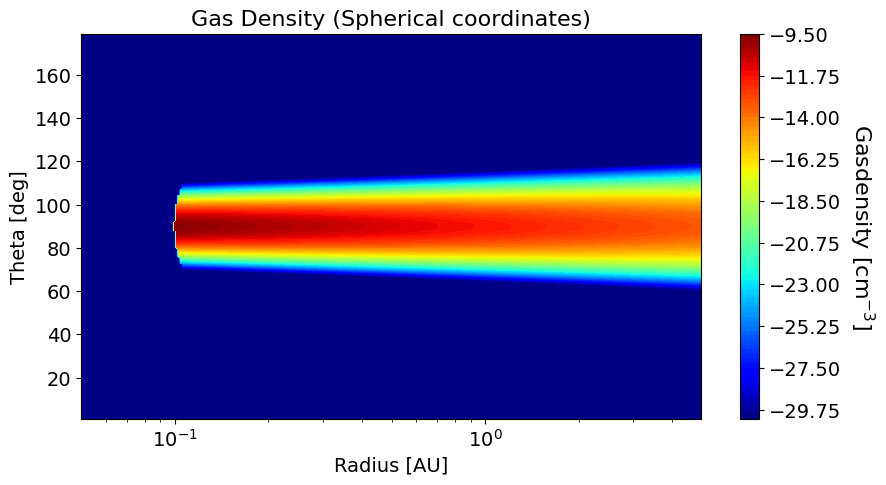

In [7]:
title = "Gas Density (Spherical coordinates)"
myMod.plot_attr("gasdensity", figsize=figsize, zlog=True,
                xlog=xlog, xscaler=xscaler, xunit=xunit,
                yscaler=yscaler, yunit=yunit, levels=levels,
                cmap='jet', title=title, axisfontsize=axisfontsize,
                titlefontsize=titlefontsize, tickfontsize=tickfontsize,
                dosave=False)

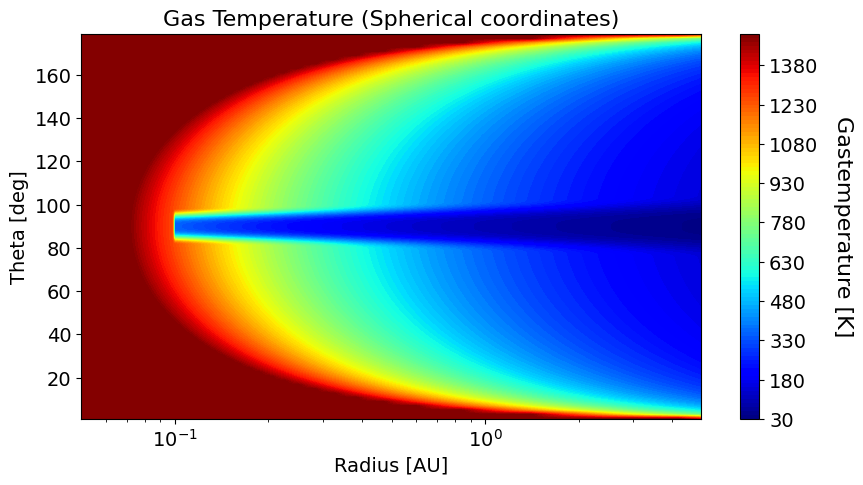

In [8]:
title = "Gas Temperature (Spherical coordinates)"
myMod.plot_attr("gastemperature", figsize=figsize, xlog=xlog, xscaler=xscaler, xunit=xunit,
                yscaler=yscaler, yunit=yunit, levels=levels,
                cmap='jet', title=title, axisfontsize=axisfontsize,
                titlefontsize=titlefontsize, tickfontsize=tickfontsize,
                dosave=False)

In [9]:
# regrid from radlite spherical coordinates (r,theta) into (R,Z) cylindrical coordinates
r = myMod.get_attr("radius") / 1.5e13
theta = myMod.get_attr("theta")
nr = r.size
nt = theta.size

logdens = np.log10(myMod.get_attr("gasdensity"))
Tgas = myMod.get_attr("gastemperature")
dens_spline = RectBivariateSpline(theta, r, logdens)
Tgas_spline = RectBivariateSpline(theta, r, Tgas)

nR = 200
R = np.logspace(-1.3, 0.7, nR)
nZ = 100
Z = np.logspace(-2, 0.7, nZ)

logdens_RZ = np.zeros((nZ, nR))
Tgas_RZ = np.zeros((nZ, nR))
for j in range(nR):
    for i in range(nZ):
        r1 = np.sqrt(R[j]**2 + Z[i]**2)
        t1 = np.arctan(R[j]/Z[i])
        logdens_RZ[i,j] = dens_spline(t1, r1)
        Tgas_RZ[i,j] = Tgas_spline(t1, r1)


<a list of 12 text.Text objects>

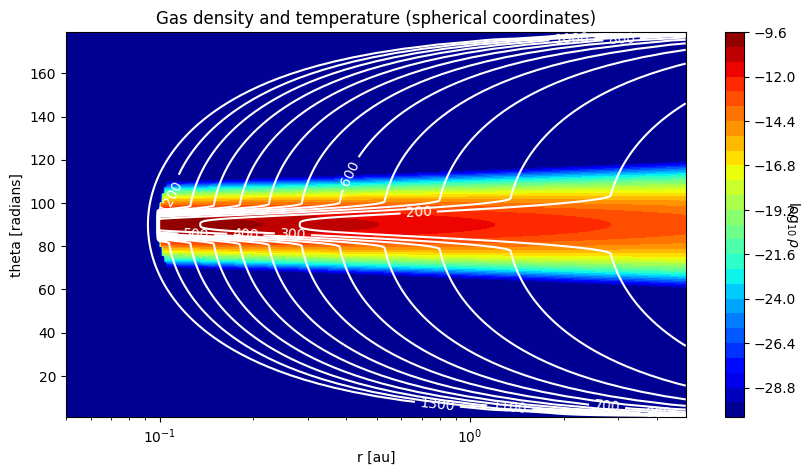

In [10]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

c1 = ax.contourf(r, np.degrees(theta), logdens, 30, cmap='jet')
ax.set_xlabel('r [au]')
ax.set_ylabel(r'theta [radians]')
ax.set_xscale('log')
ax.set_title('Gas density and temperature (spherical coordinates)')
cb = plt.colorbar(c1)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)

Tlevs = (2+np.arange(12))*100
c2 = ax.contour(r, np.degrees(theta), Tgas, Tlevs,  colors='w', linestyles='solid')
ax.clabel(c2, inline=1, fontsize=10)

#ax.plot(r_thick, np.degrees(theta_thick),  colors='black', linestyles='solid', linewidths=5, alpha=0.4)

<a list of 12 text.Text objects>

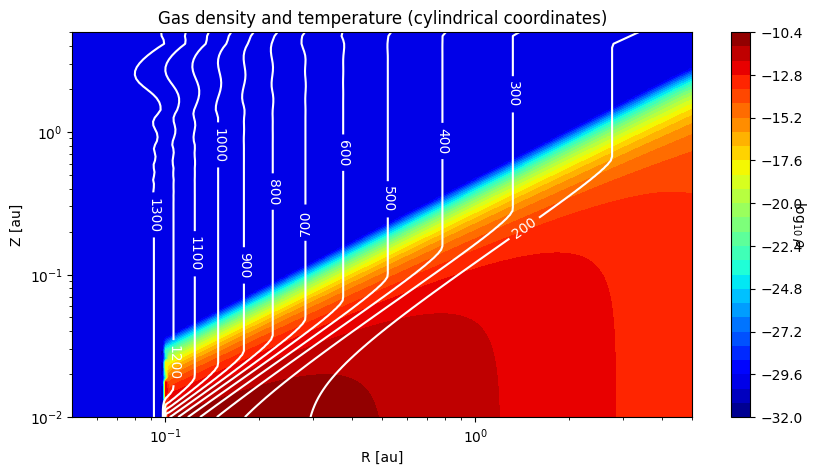

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

c1 = ax.contourf(R, Z, logdens_RZ, 30, cmap='jet')
ax.set_xlabel('R [au]')
ax.set_ylabel(r'Z [au]')
ax.set_title('Gas density and temperature (cylindrical coordinates)')
ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(c1)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)

Tlevs = (2+np.arange(12))*100
c2 = ax.contour(R, Z, Tgas_RZ, Tlevs,  colors='w', linestyles='solid')
ax.clabel(c2, inline=1, fontsize=10)


#----------------------------------------------------------
# calculate tau=1 surface at 0.5 microns
# this is from midplane vertically up so in cyleindrical coordinates
# BUT this does not agree with the getTau module using the new format so do not use
# (also need to uncomment a line in radmc.py to make it work so a bit untested perhaps?)
#RM = radmc.radmc_model('./')
#R_thick, Z_thick = RM.surface_at_tau(1, wave=0.5)
#R_thick /= 1.5e13
#Z_thick /= 1.5e13
#ax.plot(R_thick, Z_thick,  color='black', ls='solid', lw=5, alpha=0.3)
#----------------------------------------------------------

In [12]:
# calculate velocity field in cylindrical coordinates and then regrid
r = myMod.get_attr("radius") / 1.5e13
theta = myMod.get_attr("theta")
nr = r.size
nt = theta.size // 2
theta = theta[0:nt]

vrad = myMod.get_attr("velocity_radial") / 1e5
vtheta = myMod.get_attr("velocity_theta") / 1e5
vphi = myMod.get_attr("velocity_phi") / 1e5

rr, tt = np.meshgrid(r, theta)
vR = vrad*np.sin(tt) - vtheta*np.cos(tt)
vZ = vrad*np.cos(tt) + vtheta*np.sin(tt)
vR_spline = RectBivariateSpline(theta, r, vR)
vZ_spline = RectBivariateSpline(theta, r, vZ)
vphi_spline = RectBivariateSpline(theta, r, vphi)

# sparse grid because otherwise the quiver plot is too crowded
nR = 15
Rv = np.logspace(-1.3, 0.7, nR)
nZ = 10
Zv = np.logspace(-2, 0.7, nZ)

vrad_RZ = np.zeros((nZ, nR))
vtheta_RZ = np.zeros((nZ, nR))
vR_RZ = np.zeros((nZ, nR))
vZ_RZ = np.zeros((nZ, nR))
vphi_RZ = np.zeros((nZ, nR))
for j in range(nR):
    for i in range(nZ):
        r1 = np.sqrt(Rv[j]**2 + Zv[i]**2)
        t1 = np.arctan(Rv[j]/Zv[i])
        vR_RZ[i,j] = vR_spline(t1, r1)
        vZ_RZ[i,j] = vZ_spline(t1, r1)
        vphi_RZ[i,j] = vphi_spline(t1, r1)


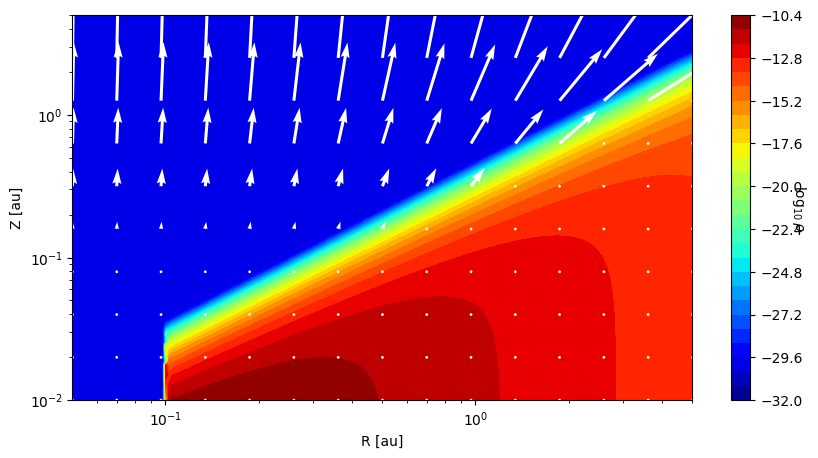

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

c1 = ax.contourf(R, Z, logdens_RZ, 30, cmap='jet')
ax.set_xlabel('R [au]')
ax.set_ylabel(r'Z [au]')
ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(c1)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)

# show the velocity field
ax.quiver(Rv, Zv, vR_RZ, vZ_RZ, color='white')

#c3 = ax.contour(r, z, tau_rz.T, [1.0],  colors='black', linestyles='solid', linewidths=5, alpha=0.4)

## Running RADLite

In [14]:
#Run RADLite
myMod.run_radlite()

Attempting to create run directory rundir_spectrum...
rundir_spectrum already exists. Will overwrite files within.
All input files and final data will be saved to the following folder in the current directory: rundir_spectrum
Running RADLite on 7 core(s)...
Generating working directory for cores called: ./rundir_spectrum/workingdir
All core outputs will be stored in: ./rundir_spectrum/outputdir
Replacing previous ./rundir_spectrum/outputdir...
Prepping 0th core...
Starting 0th core in ./rundir_spectrum/workingdir/workingdir_cpu0/...


mkdir: rundir_spectrum: File exists
mkdir: ./rundir_spectrum/outputdir: File exists


0th core has started working...
Prepping 1th core...
Starting 1th core in ./rundir_spectrum/workingdir/workingdir_cpu1/...
1th core has started working...
Prepping 2th core...
Starting 2th core in ./rundir_spectrum/workingdir/workingdir_cpu2/...
2th core has started working...
Prepping 3th core...
Starting 3th core in ./rundir_spectrum/workingdir/workingdir_cpu3/...
3th core has started working...
Prepping 4th core...
Starting 4th core in ./rundir_spectrum/workingdir/workingdir_cpu4/...
4th core has started working...
Prepping 5th core...
Starting 5th core in ./rundir_spectrum/workingdir/workingdir_cpu5/...
5th core has started working...
Prepping 6th core...
Starting 6th core in ./rundir_spectrum/workingdir/workingdir_cpu6/...
Done starting core(s)!6th core has started working...
6th core does not have any lines to process.  Exiting...
(Function _run_core took 4.83e-03s.)

(Function _write_core_levelpopinp took 1.58e-01s.)
(Function _write_core_levelpopinp took 1.52e-01s.)
(Function _

## Plot spectra

In [15]:
mySpec = RDL.RadliteSpectrum(infilename=inspecfilename)

--------------------------------------------------
Welcome to RADLite Version 1.3.0!

RADLite Version 1.2 (in IDL) was written by:
Klaus Pontoppidan (pontoppi@stsci.edu)
Kees Dullemond
Alex Lockwood
Rowin Meijerink

RADLite Version 1.3.0 (in Python) was written by:
Jamila Pegues (jamila.pegues@cfa.harvard.edu)
Klaus Pontoppidan (pontoppi@stsci.edu)

unofficial changes to work with radmc3dPy
Jonathan Williams (jw@hawaii.edu)
--------------------------------------------------



Welcome!  You have successfully initialized an instance of RadliteSpectrum(). You can use this instance to process and plot RADLite output. Start by running the gen_spec() method to process RADLite spectra.

(Function __init__ took 1.02e-03s.)


In [16]:
# Note that in jupyter notebooks, this creates an error ("THE_PROCESS_HAS_FORKED...") which I cannot seem to avoid
# but it appears harmless... (and it doesn't happen in vscode)
mySpec.gen_spec()

Starting the gen_spec method!
Reviewing user-defined parameters for spectra...
Chosen dist [pc]: 140.0
Chosen obsres [km/s]: 3.0
Chosen vsampling [km/s]: 1.5

Starting process of reading RADLite output...
Extracting all Radlite output from the following list of files: ['rundir_spectrum/outputdir/']...
Starting a pool of 7 cores to extract RADLite output...
The cores have finished extracting RADLite output!

Done processing all RADLite runs!
There are a total of 6 molecular lines across all given RADLite runs.

Removing any duplicate line occurrences...
6 molecular lines are being kept.
Now there are 6 lines.

Doing light checks for signs of incompatible sources...
Light checks passed!

Done with process of reading RADLite output!

(Function _read_radliteoutput took 7.74e-01s.)
Starting to process read-in RADLite molecular line data...
NOTE: All interpolation will be done using user-specified interpolation scheme ('linear').
Broadening velocity span for each line...
Interpolating and su

(Function plot_spec took 2.69e-02s.)
(Function plot_spec took 2.85e-03s.)


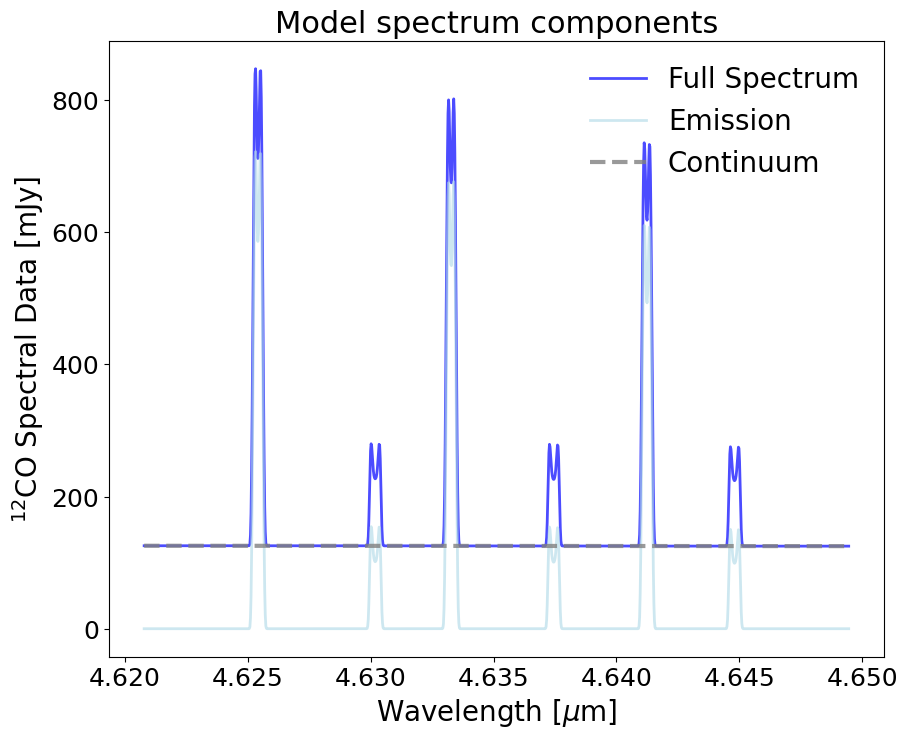

(Function plot_spec took 1.92e-01s.)


In [17]:
fig = plt.figure(figsize=(10, 8))
yscaler = 1000                     # Scale the y-axes from Jy to mJy

mySpec.plot_spec("spectrum",
                 fig=fig,
                 dopart=True,
                 linecolor="blue", linewidth=2, alpha=0.7,
                 yscaler=yscaler,
                 leglabel="Full Spectrum")

mySpec.plot_spec("emission",
                 fig=fig,
                 dopart=True,
                 linecolor="lightblue", linewidth=2, alpha=0.6, linestyle="-",
                 yscaler=yscaler,
                 leglabel="Emission")

mySpec.plot_spec("continuum",
                 fig=fig,
                 dopart=False,
                 linecolor="gray", linewidth=3, alpha=0.8, linestyle="--",
                 yscaler=yscaler,
                 ylabel=r"$^{12}$CO Spectral Data", yunit="mJy",
                 dolegend=True, legloc="upper right",
                 leglabel="Continuum",
                 axisfontsize=20, titlefontsize=22,
                 tickfontsize=18, legfontsize=20,
                 title="Model spectrum components")

In [18]:
fitsname = "radlite_spectrum.fits"
overwrite = True
mySpec.write_fits(fitsname, overwrite=overwrite)

Starting the write_fits method!
Saving spectra and molecular info in a .fits file...


Data has been successfully saved to radlite_spectrum.fits!
(Function write_fits took 2.32e-02s.)
